In [1]:
%load_ext autoreload
%autoreload 2
import os
import random
from collections import OrderedDict, defaultdict
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, Compose, Normalize
import numpy as np
import pandas as pd
import PIL
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
import pyro
from pyro.distributions import Normal, Bernoulli
from pyro.infer import SVI, Trace_ELBO

from mnist import MNIST, MNISTTrain, MNISTTest

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
pyro.set_rng_seed(0)

/env_nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
batch_size = 1024 * 4

In [3]:
train_loader = DataLoader(dataset=MNISTTrain(transform=Compose([ToTensor(),])),
                          batch_size=batch_size, shuffle=True, num_workers=2)

In [4]:
test_loader = DataLoader(dataset=MNISTTest(transform=Compose([ToTensor(),])),
                          batch_size=batch_size, shuffle=False)


In [5]:
class Encoder(nn.Module):
    
    def __init__(self, hidden, zdim):
        super().__init__()
        self.fc1 = nn.Linear(784, hidden)
        self.std_net = nn.Linear(hidden, zdim)
        self.mu_net = nn.Linear(hidden, zdim)
        
            
    def forward(self, x):
        x = x.squeeze().view(-1, 784)
        feat1 = F.relu(self.fc1(x))
        mean = self.mu_net(feat1)
        std = torch.exp(self.std_net(feat1))
        return mean, std

class Decoder(nn.Module):
    
    def __init__(self, zdim, hidden):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(zdim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 784),
            nn.Sigmoid()
            )
    
    def forward(self, z):
        x_hat = self.net(z)
        # x_hat = x_hat.view(z.size(0), 1, 28, 28)
        return x_hat


class VAE(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.zdim = 50
        self.encoder = Encoder(hidden=400, zdim=self.zdim)
        self.decoder = Decoder(hidden=400, zdim=self.zdim,)
        
        self.apply(self.reset_parameters)
    
    def reset_parameters(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_normal_(module.weight, )
            if module.bias is not None:
                nn.init.constant_(module.bias, 0.)

    def model(self, x):
        pyro.module("decoder", self.decoder)
        img = x.ge(0.5).to(torch.float32).reshape(x.shape[0], 784)
        with pyro.plate("data", x.size(0)):
            mean = x.new_zeros((x.size(0), self.zdim))
            std = x.new_ones((x.size(0), self.zdim))
            # print(x)
            z = pyro.sample("z", Normal(mean, std).to_event(1))
            x_hat = self.decoder(z)
            # print("---")
            # print(x_hat)
            # imgs.append(x)
            # imgs.append(x_hat)
            
            pyro.sample("x_hat", Bernoulli(x_hat).to_event(1), obs=img)
        return x_hat
            
    
    def guide(self, x):
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.size(0)):
            mean, std = self.encoder(x)
            pyro.sample("z", Normal(mean, std).to_event(1))
    
    def reconstruct_img(self, x):
        with torch.no_grad():
            mean, std = self.encoder(x)
            print(mean.size(), std.size())
            z = Normal(mean, std).sample()
            x_hat = self.decoder(z)
            return x_hat
            

In [6]:

def train():
    pyro.clear_param_store()
    vae = VAE()
    vae.cuda()
    vae.train()
    optimizer = pyro.optim.Adam({"lr": 5e-4})
    svi = SVI(vae.model, vae.guide, optimizer, Trace_ELBO())
    epochs = 25
    losses = []
    it = 0
    for i in range(epochs):
        print("Starting Epoch ", i, "...")
        for j, (img, label) in enumerate(train_loader):
            img = img.cuda()
            img /= 255.0
            loss = svi.step(img)
            # print(loss)
            losses.append(loss / batch_size)
            if it % 50 == 0:
                print(f"Epoch: {i}, batch: {j}, loss: {np.mean(losses[-100:])}")
            it += 1
    return vae, losses
    
        

In [7]:
model, losses = train()

Starting Epoch  0 ...
Epoch: 0, batch: 0, loss: 573.3875427246094
Epoch: 0, batch: 50, loss: 353.71470731847427
Starting Epoch  1 ...
Epoch: 1, batch: 41, loss: 295.1570189666748
Starting Epoch  2 ...
Epoch: 2, batch: 32, loss: 222.86134746551514
Starting Epoch  3 ...
Epoch: 3, batch: 23, loss: 192.59916641235353
Starting Epoch  4 ...
Epoch: 4, batch: 14, loss: 173.7318946647644
Starting Epoch  5 ...
Epoch: 5, batch: 5, loss: 162.4774200630188
Epoch: 5, batch: 55, loss: 155.02336338043213
Starting Epoch  6 ...
Epoch: 6, batch: 46, loss: 148.83620403289794
Starting Epoch  7 ...
Epoch: 7, batch: 37, loss: 143.19157779693603
Starting Epoch  8 ...
Epoch: 8, batch: 28, loss: 138.74401424407958
Starting Epoch  9 ...
Epoch: 9, batch: 19, loss: 134.97924503326416
Starting Epoch  10 ...
Epoch: 10, batch: 10, loss: 131.88202741622925
Starting Epoch  11 ...
Epoch: 11, batch: 1, loss: 129.1868341445923
Epoch: 11, batch: 51, loss: 127.30475858688355
Starting Epoch  12 ...
Epoch: 12, batch: 42, loss

In [8]:
def plot_images(model, idx):
    with torch.no_grad():
        model.eval()
        img,label = test_loader.dataset[idx]
        img = img.unsqueeze(0).cuda()
        img /= 255.0
        out = model.reconstruct_img(img)
        print(out.size())
        out = out[0].detach().cpu().view(1, 28, 28).permute(1, 2, 0)
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(img.squeeze(0).permute(1, 2, 0).detach().cpu())
        ax2.imshow(out)
        fig.suptitle(label.item())

torch.Size([1, 50]) torch.Size([1, 50])
torch.Size([1, 784])


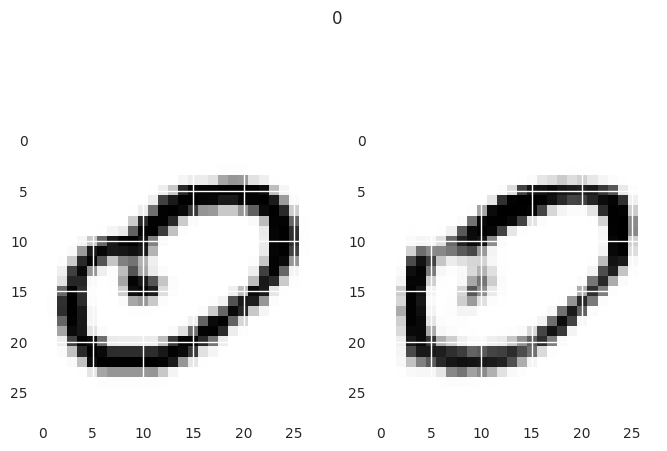

In [10]:
plot_images(model, 0)

torch.Size([1, 50]) torch.Size([1, 50])
torch.Size([1, 784])


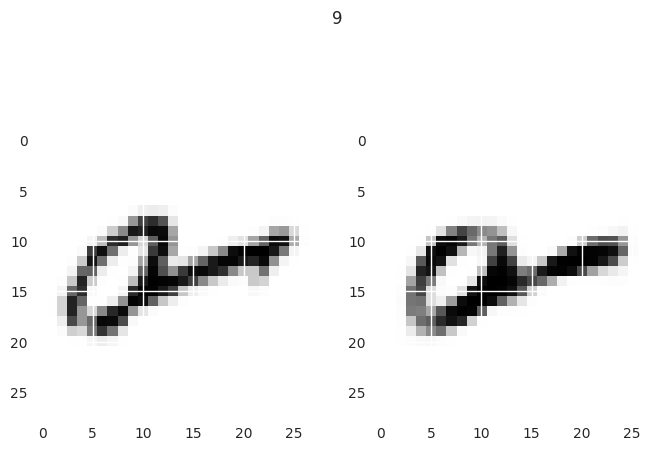

In [11]:
plot_images(model, 100)